# Up/Down decon with stochastic gradient algorithms

In [59]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch
import torchvision
import torch.nn as nn
import pylops_gpu

from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt,convolve
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from torch.autograd import gradcheck
from pylops_gpu.utils.backend import device
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from stochmdd import MDDminibatch, MDDpage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data loading

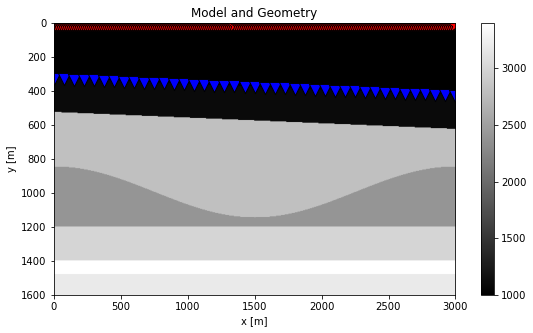

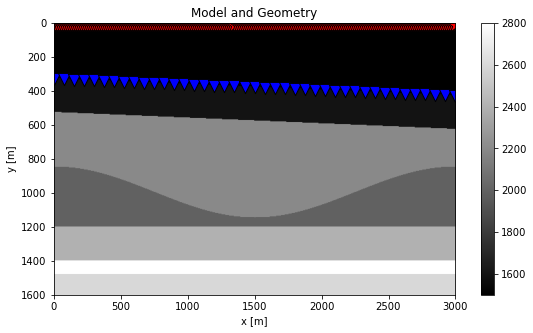

In [60]:
datapath = '../Data'

inputfile = os.path.join(datapath, 'input_dipping_recsolid.npz')

vel_dir = 1500.0 # velocity of water
vel_sep = 1600.0 # velocity at separation level
rho_sep = 1100.0 # density at separation level

#method = 'sum'
#method = 'rec_ana'
method = 'src_ana'
#method = 'src_inv'

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
r = r[:, 201:]
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = s[0, 1]-s[0, 0]

# Model
rho = inputdata['rho']
vel = inputdata['vel']

# Axes
nt, dt = 941, 0.005
t = np.arange(nt) * dt
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

plt.figure(figsize=(9,5))
im = plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im);

Up/down separated data

In [61]:
data = np.load('../Data/updown_dipping_belowseabed_%s.npz'% method)

pup = data['pup'] 
pdown = data['pdown'] 

Reference Reflection response

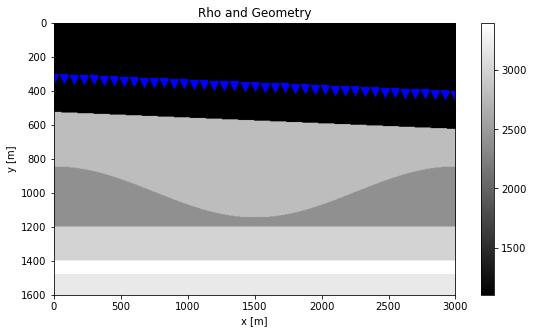

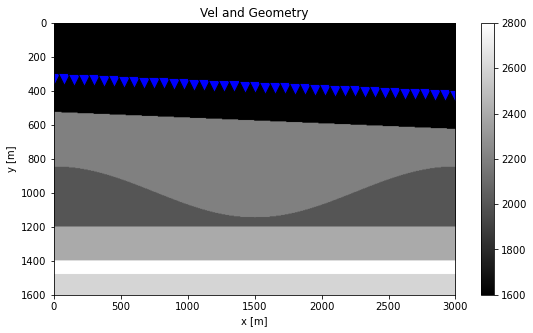

In [62]:
inputfile = os.path.join(datapath, 'input_dipping_noseabed_recsolid.npz')
inputdata = np.load(inputfile)

# data
R = -inputdata['vz_noseabed']

# Model
rho_ref = inputdata['rho_noseabed']
vel_ref = inputdata['vel_noseabed']

plt.figure(figsize=(9,5))
im = plt.imshow(rho_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Rho and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Vel and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im);

## Data preparation

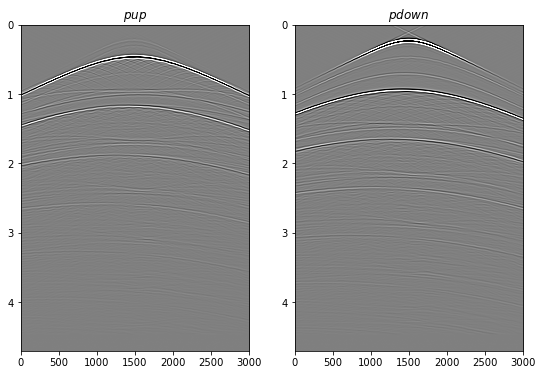

In [63]:
# Pad data with zero at the end (to avoid wrap around)
npad = 50 # 400
pdown = np.pad(pdown, ((0, 0), (0, npad), (0, 0)))#.astype('float32')
pup = np.pad(pup, ((0, 0), (0, npad), (0, 0)))#.astype('float32')
R = np.pad(R, ((1, npad), (0, 0) ))#.astype('float32')
ntpad = pup.shape[1]
tpad = np.arange(ntpad) * dt
tpad2 = np.hstack((-tpad[::-1], tpad[1:]))


fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup[ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown[ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight');

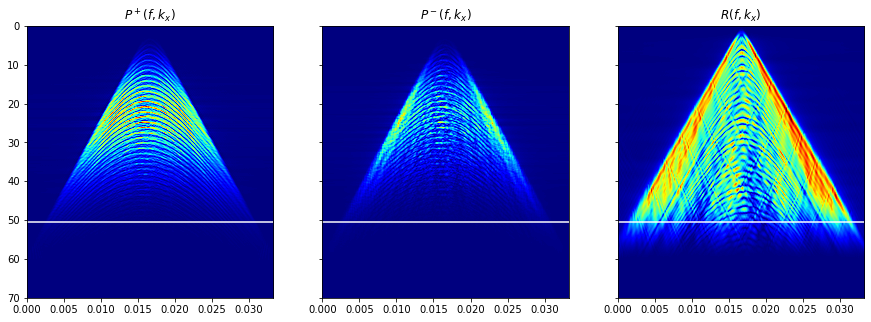

In [64]:
# check max frequency to use
nfmax=250#550
nfft = ntpad#2**11

FFTop = FFT2D(dims=[nr, ntpad], nffts=[nfft, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[ns//2].T.flatten()).reshape(nfft, nfft)
PDOWN = (FFTop*pdown[ns//2].T.flatten()).reshape(nfft, nfft)
RTRUE = (FFTop*R.T.ravel()).reshape(nfft, nfft)

# mask away high freqs
mask = np.zeros((nfft, nfft))
mask[:, :nfmax] = 1
mask[:, -nfmax:] = 1
mask = filtfilt(np.ones(50)/50, 1, mask, axis=1)
RTRUE *= mask
R = np.real(FFTop.H * RTRUE.ravel()).reshape(nr, ntpad).T

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight')
im=axs[2].imshow(np.fft.fftshift(np.abs(RTRUE[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[2].axhline(FFTop.f2[nfmax], color='w')
axs[2].set_title(r'$R(f, k_x)$')
axs[2].axis('tight')
axs[2].set_ylim(70, 0);

## Benchmark MDD

In [65]:
def errnorm(m, mtrue, enorm):
    enorm.append(np.linalg.norm(m/m.max() - mtrue/mtrue.max()))

In [66]:
# MDD two-sided
R = np.concatenate((np.zeros((ntpad-1, nr)), R), axis=0)

niter = 20
bench_enorm = []
Rinv, Radj = MDD(pdown.transpose(0, 2, 1), pup[:, :, nr//2], dt=dt, dr=dr, 
                 nfmax=2*nfmax, twosided=True, add_negative=True, 
                 adjoint=True, psf=False, dtype='complex64', dottest=True,
                 **dict(damp=1e-10, niter=niter, show=1, 
                        callback=lambda x: errnorm(x, R.ravel(), bench_enorm),))

Dot test passed, v^T(Opu)=2073.276445 - u^T(Op^Tv)=2073.276445
CGLS
-----------------------------------------------------------
The Operator Op has 398181 rows and 398181 cols
damp = 1.000000e-10	tol = 1.000000e-04	niter = 20
-----------------------------------------------------------
    Itn           x[0]              r1norm          r2norm
     1        -6.2707e-10         8.1465e+00      8.1465e+00
     2        -2.0519e-06         6.1979e+00      6.1979e+00
     3        -5.8550e-07         4.7819e+00      4.7819e+00
     4         9.3129e-07         3.7647e+00      3.7647e+00
     5         2.2781e-06         3.0572e+00      3.0572e+00
     6         1.1643e-06         2.5819e+00      2.5819e+00
     7        -8.5407e-08         2.2590e+00      2.2590e+00
     8        -2.3297e-06         2.0121e+00      2.0121e+00
     9        -3.7446e-06         1.8080e+00      1.8080e+00
    10        -2.7560e-06         1.6355e+00      1.6355e+00
    11        -1.1072e-06         1.4913e+00 

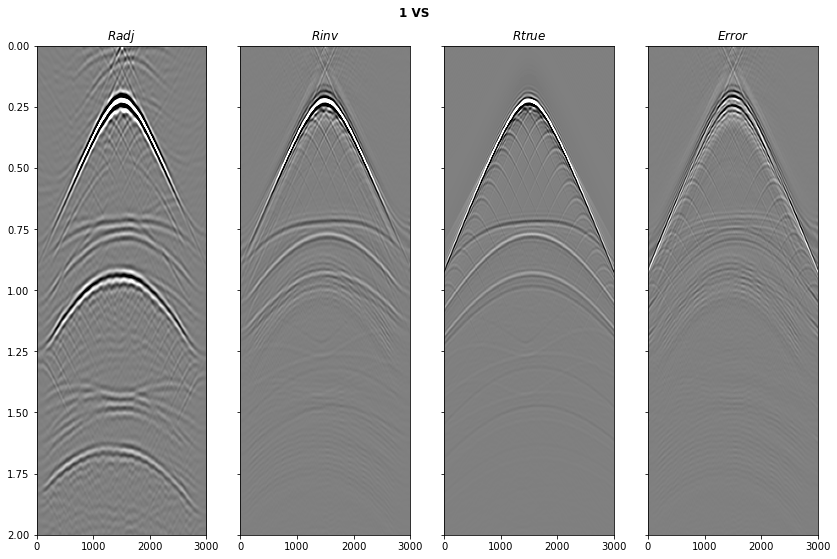

In [67]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(14,9))
fig.suptitle('1 VS', fontweight='bold', y=0.94)
axs[0].imshow(Radj.T, cmap='gray', 
              vmin=-0.2*np.abs(Radj).max(), vmax=0.2*np.abs(Radj).max(),
              extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(Rinv.T, cmap='gray', 
              vmin=-0.2*np.abs(Rinv).max(), vmax=0.2*np.abs(Rinv).max(),
              extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(R, cmap='gray', 
              vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
              extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$Rtrue$')
axs[2].axis('tight')
axs[2].set_ylim(2, -2)
axs[3].imshow(Rinv.T/np.max(Rinv.T)-R/np.max(R), cmap='gray', 
              vmin=-0.2, vmax=0.2,
              extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$Error$')
axs[3].axis('tight')
axs[3].set_ylim(2, 0);

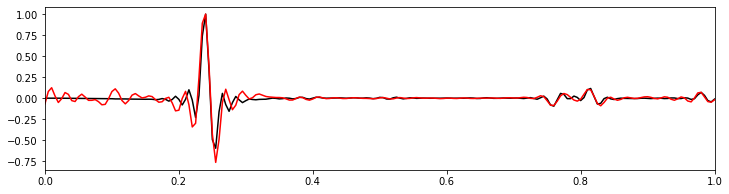

In [68]:
plt.figure(figsize=(12, 3))
plt.plot(tpad2, R[:, ns//2]/np.max(R[:, ns//2]), 'k')
plt.plot(tpad2, Rinv[ns//2]/np.max(Rinv[ns//2]), 'r')
plt.xlim(0, 1.);

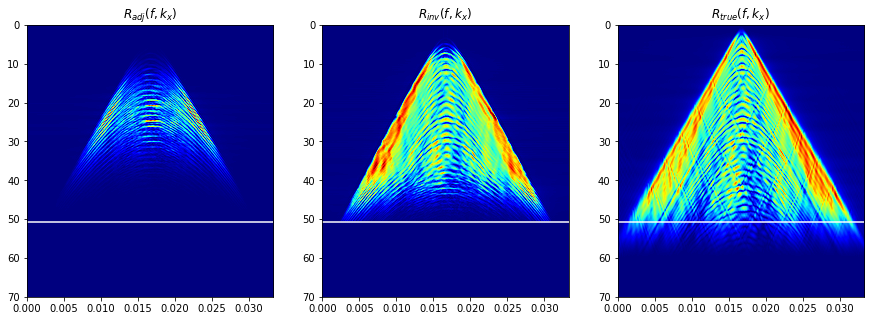

In [69]:
nfft = 2*ntpad-11

FFTop = FFT2D(dims=[nr, 2*ntpad-1], nffts=[nfft, nfft], sampling=[dr, dt])

RADJ = (FFTop*Radj.ravel()).reshape(nfft, nfft)
RINV = (FFTop*Rinv.ravel()).reshape(nfft, nfft)
RTRUE = (FFTop*R.T.ravel()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(RADJ[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RADJ).max())
axs[0].axhline(FFTop.f2[2*nfmax], color='w')
axs[0].set_title(r'$R_{adj}(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(70, 0)
im=axs[1].imshow(np.fft.fftshift(np.abs(RINV[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RINV).max())
axs[1].axhline(FFTop.f2[2*nfmax], color='w')
axs[1].set_title(r'$R_{inv}(f, k_x)$')
axs[1].axis('tight')
axs[1].set_ylim(70, 0)
im=axs[2].imshow(np.fft.fftshift(np.abs(RTRUE[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[2].axhline(FFTop.f2[2*nfmax], color='w')
axs[2].set_title(r'$R_{true}(f, k_x)$')
axs[2].axis('tight');
axs[2].set_ylim(70, 0);

## Stochastic MDD

In [70]:
# 1.
#nepochs = niter
#batch_size = 21

# 2.
#nepochs = niter
#batch_size = 11

# 3.
nepochs = niter
batch_size = 32

# 4.
#nepochs = niter
#batch_size = 64


no_of_batches=np.ceil(ns/batch_size)
lossdict = {}
avgdict = {}
enormdict = {}
mdict = {}

In [71]:
pup = pup[:, :, nr//2]
pdown = np.swapaxes(pdown, 2, 1)

pup2 = np.concatenate((np.zeros((ns, ntpad-1)), pup), axis=-1).T
pdown2 = np.concatenate((np.zeros((ns, nr, ntpad-1)), pdown), axis=-1)

In [72]:
pdown_fft = np.fft.rfft(pdown2, 2*ntpad-1, axis=-1)
pdown_fft = pdown_fft[...,:2*nfmax]
pdown_fft = pdown_fft.transpose(2,0,1)

MDCop=MDC(pdown_fft, nt=2*ntpad-1, nv=1, dt=dt, dr=dr, 
          twosided=True, transpose=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=0, verb=True);

Dot test passed, v^T(Opu)=-74519.200869 - u^T(Op^Tv)=-74519.200869


In [73]:
# Adjoint
madj = MDCop.H * pup2.ravel()
madj = madj.reshape(2*ntpad-1, nr)

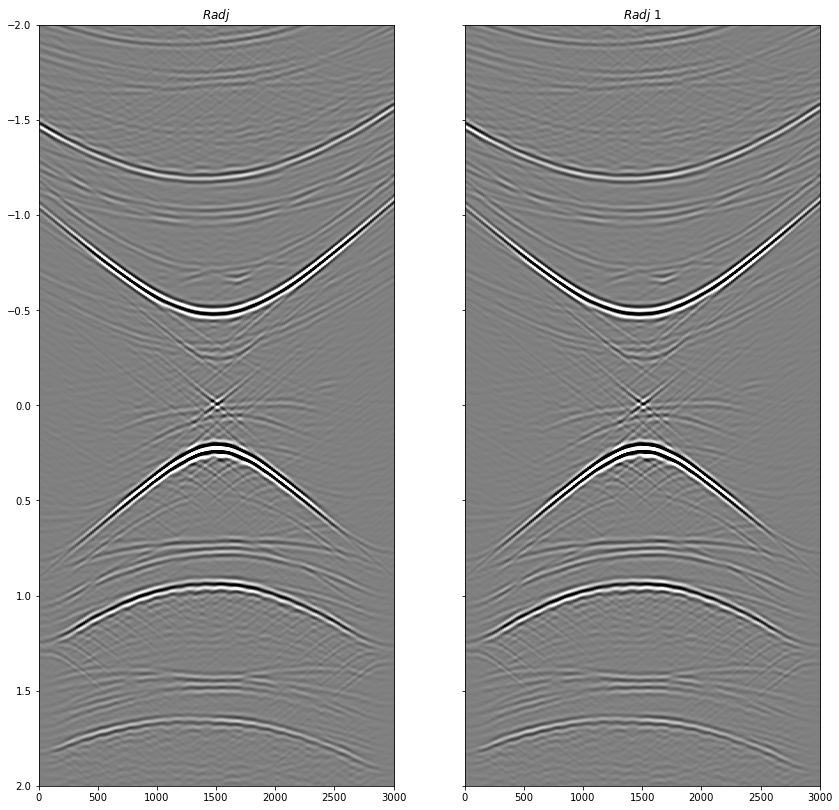

In [74]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14,14))
axs[0].imshow(Radj.T, cmap='gray', 
              vmin=-0.2*np.abs(Radj).max(), vmax=0.2*np.abs(Radj).max(),
              extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(madj, cmap='gray',
              vmin=-0.2*np.abs(madj).max(), vmax=0.2*np.abs(madj).max(),
              extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$Radj$ 1')
axs[1].axis('tight')
axs[1].set_ylim(2, -2);

In [75]:
R = torch.from_numpy(R)
pdown_fft = torch.from_numpy(5*pdown_fft)
pup2 = torch.from_numpy(5*pup2)

In [76]:
pup2.dtype, pdown_fft.dtype

(torch.float64, torch.complex128)

### SGD

In [77]:
lr = {}
lr[11] = 0.01
lr[21] = 0.01
lr[32] = 0.01
lr[64] = 0.01

model, dmod, lossdict['SGD'], avgdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup2, torch.optim.SGD, 
                              nepochs, batch_size, mtrue=R, seed=0, epochprint=5,
                              **dict(lr=lr[batch_size], weight_decay=0))
mdict["SGD"] = model.detach().numpy()

epoch:   5, loss : 9.4438e-04, loss avg : 1.2789e-03
epoch:  10, loss : 6.1985e-04, loss avg : 5.5551e-04
epoch:  15, loss : 3.6275e-04, loss avg : 3.2702e-04
epoch:  20, loss : 2.5215e-04, loss avg : 2.2819e-04


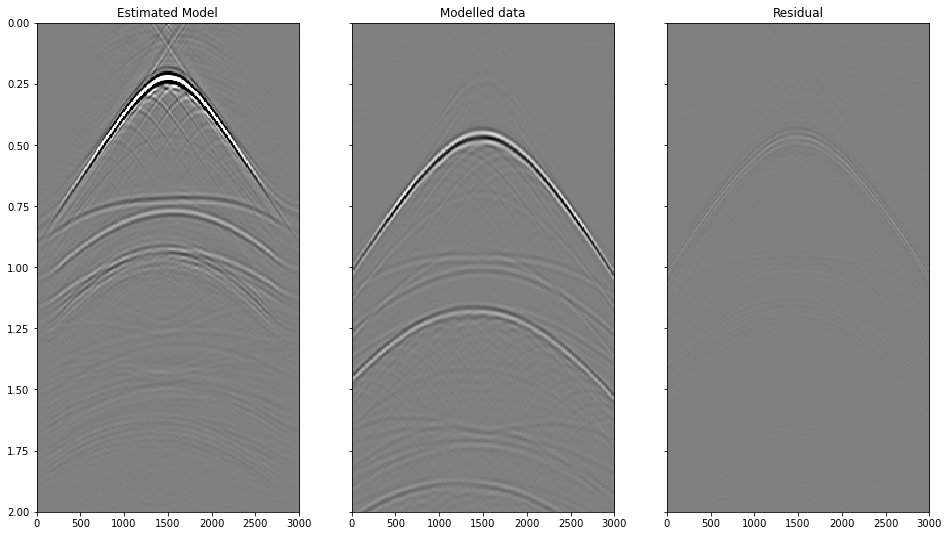

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-1e-3, vmax=1e-3,
           extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup2.detach().numpy().max(), vmax=pup2.detach().numpy().max(),
           extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
ax2.set_title('Modelled data')
ax3.imshow((dmod-pup2).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup2.detach().numpy().max(), vmax=pup2.detach().numpy().max(),
           extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
ax3.set_title('Residual')
ax3.set_ylim(2, 0);

### SGD with momentum

In [80]:
lr = {}
lr[11] = 0.002
lr[21] = 0.005
lr[32] = 0.01
lr[64] = 0.01

model, dmod, lossdict['SGDMom'], avgdict['SGDMom'], enormdict['SGDMom'], _ = \
                 MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup2, torch.optim.SGD, 
                              nepochs, batch_size, mtrue=R, seed=0, epochprint=5,
                              **dict(lr=lr[batch_size], momentum=0.9, nesterov=True))

mdict["SGDMom"] = model.detach().numpy()

epoch:   5, loss : 5.7545e-04, loss avg : 8.1836e-04
epoch:  10, loss : 1.3720e-04, loss avg : 1.6891e-04
epoch:  15, loss : 5.0757e-05, loss avg : 5.5565e-05
epoch:  20, loss : 3.1150e-05, loss avg : 3.1057e-05


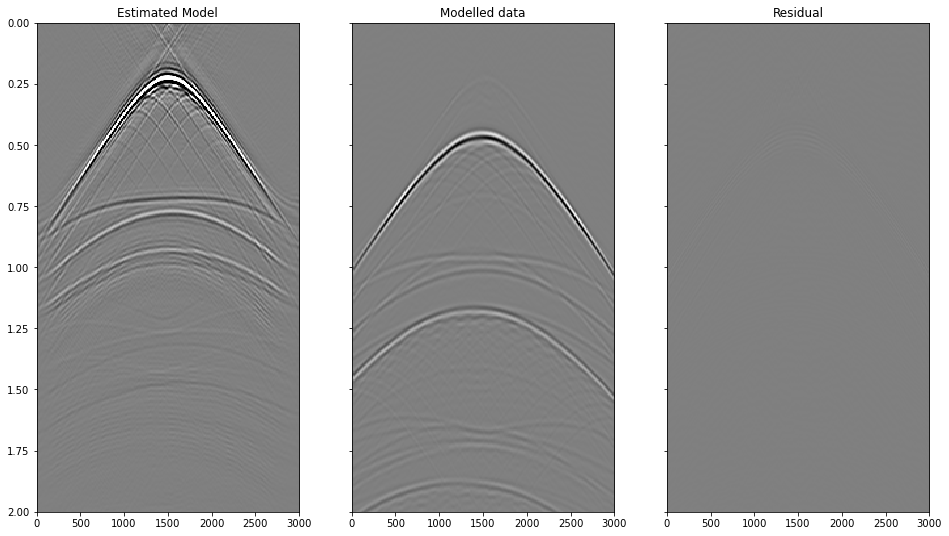

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-1e-3, vmax=1e-3,
           extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup2.detach().numpy().max(), vmax=pup2.detach().numpy().max(),
           extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
ax2.set_title('Modelled data')
ax3.imshow((dmod-pup2).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup2.detach().numpy().max(), vmax=pup2.detach().numpy().max(),
           extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
ax3.set_title('Residual')
ax3.set_ylim(2, 0);

### SGD with momentum and exponential LR

In [23]:
lr = {}
lr[11] = 0.006
lr[21] = 0.01
lr[32] = 0.01
lr[64] = 0.01

model, dmod, lossdict['SGDMom_LRexp'], avgdict['SGDMom_LRexp'], enormdict['SGDMom_LRexp'], lr = \
                 MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup2, torch.optim.SGD, 
                              nepochs, batch_size, mtrue=R, seed=0,
                              scheduler=torch.optim.lr_scheduler.ExponentialLR, epochprint=5,
                              kwargs_sched=dict(gamma=0.99, last_epoch=-1, verbose=False),
                              **dict(lr=lr[batch_size], momentum=0.9, nesterov=True))
                 
mdict["SGDMom_LRexp"] = model.detach().numpy()

epoch:   5, loss : 3.5054e-04, loss avg : 5.4268e-04
epoch:  10, loss : 8.1110e-05, loss avg : 7.4918e-05
epoch:  15, loss : 5.4442e-05, loss avg : 4.8031e-05
epoch:  20, loss : 4.1106e-05, loss avg : 4.0015e-05


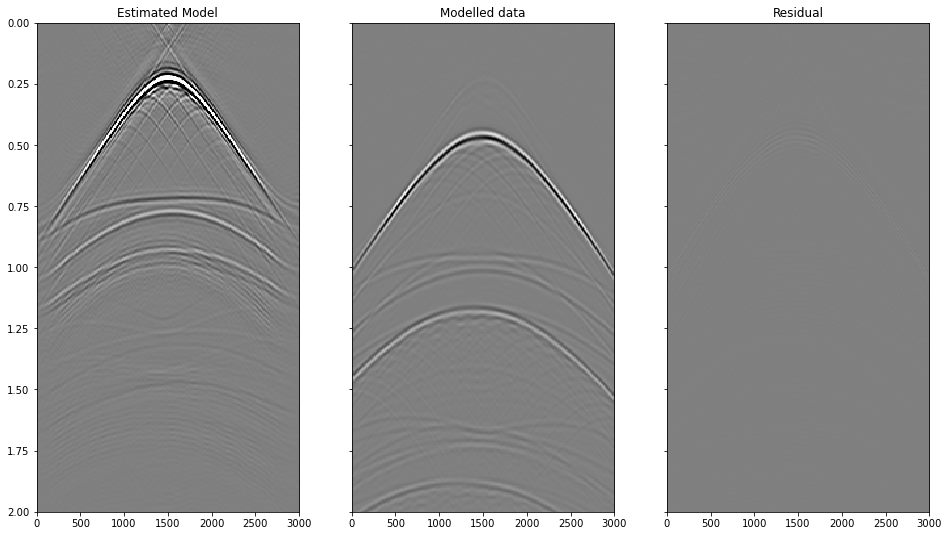

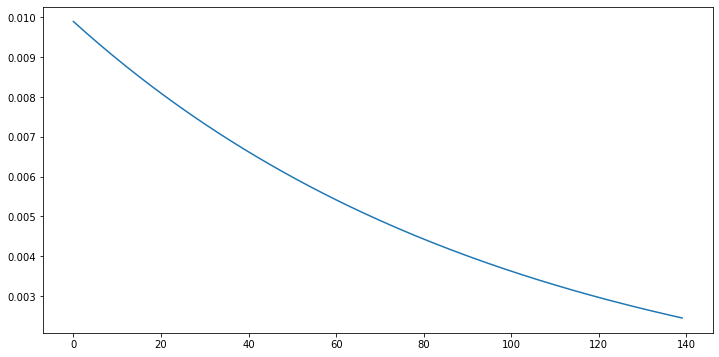

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-1e-3, vmax=1e-3,
           extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup2.detach().numpy().max(), vmax=pup2.detach().numpy().max(),
           extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
ax2.set_title('Modelled data')
ax3.imshow((dmod-pup2).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup2.detach().numpy().max(), vmax=pup2.detach().numpy().max(),
           extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
ax3.set_title('Residual')
ax3.set_ylim(2, 0)

fig = plt.figure(figsize= (12,6))
plt.plot(lr);

## Comparison

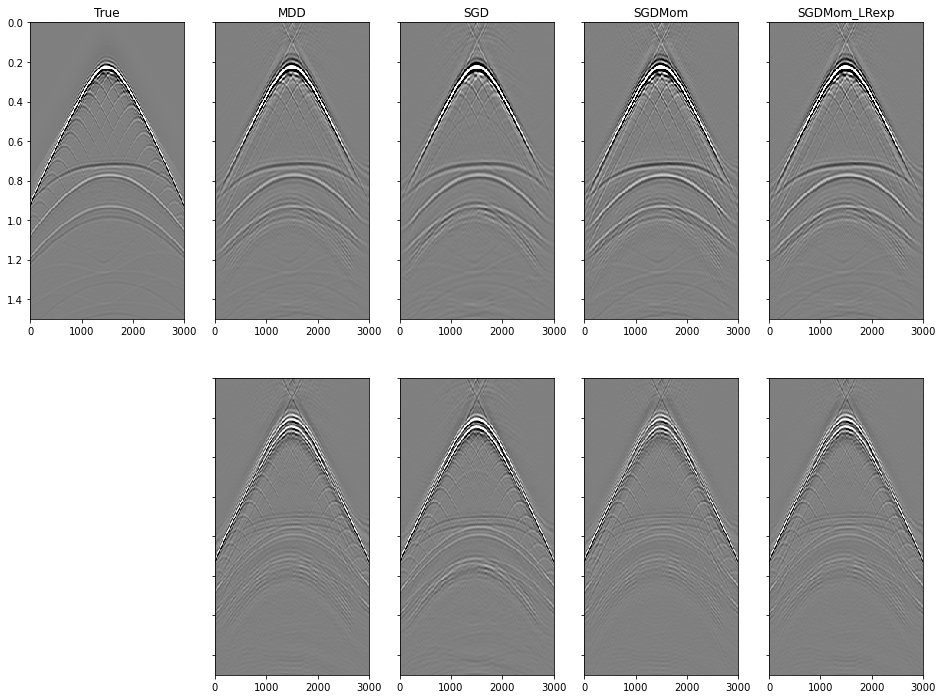

In [25]:
clip = 0.2

fig, axs = plt.subplots(2, len(mdict)+2, sharey=True, figsize=(16, 12))
axs[0][0].imshow(R, aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-clip*R.max(), vmax=clip*R.max(),
              extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
axs[0][0].axis('tight')
axs[0][0].set_title('True')
axs[0][1].imshow(Rinv.T, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*Rinv.max(), vmax=clip*Rinv.max(),
           extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
axs[0][1].axis('tight')
axs[0][1].set_title('MDD')

for iloss, loss in enumerate(mdict.keys()):
    axs[0][iloss+2].imshow(mdict[loss], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*mdict['SGD'].max(), vmax=clip*mdict['SGD'].max(),
           extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
    axs[0][iloss+2].axis('tight')
    axs[0][iloss+2].set_title(loss)
axs[0][-1].set_ylim(1.5, 0)

axs[1][0].axis('off')
axs[1][1].imshow(R/R.max()-Rinv.T/Rinv.max(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip, vmax=clip,
           extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
axs[1][1].axis('tight')

for iloss, loss in enumerate(mdict.keys()):
    axs[1][iloss+2].imshow(R/R.max()-mdict[loss]/mdict[loss].max(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip, vmax=clip,
           extent = (r[0, 0], r[0,-1], t[-1], -t[-1]))
    axs[1][iloss+2].axis('tight')
axs[1][-1].set_ylim(1.5, 0)

plt.savefig('Figs/MDDSingle_solutions_batch%d_nepoch%d' % (batch_size, nepochs))

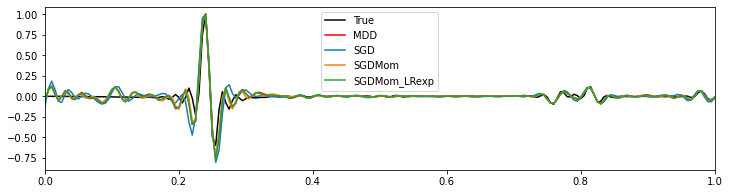

In [26]:
plt.figure(figsize=(12, 3))
plt.plot(tpad2, R[:, ns//2]/R[:, ns//2].max(), 'k', label='True')
plt.plot(tpad2, Rinv[ns//2]/Rinv[ns//2].max(), 'r', label='MDD')
for iloss, loss in enumerate(mdict.keys()):
    plt.plot(tpad2,mdict[loss][:, ns//2]/mdict[loss][:, ns//2].max(), label=loss)
plt.legend()
plt.xlim(0, 1.);

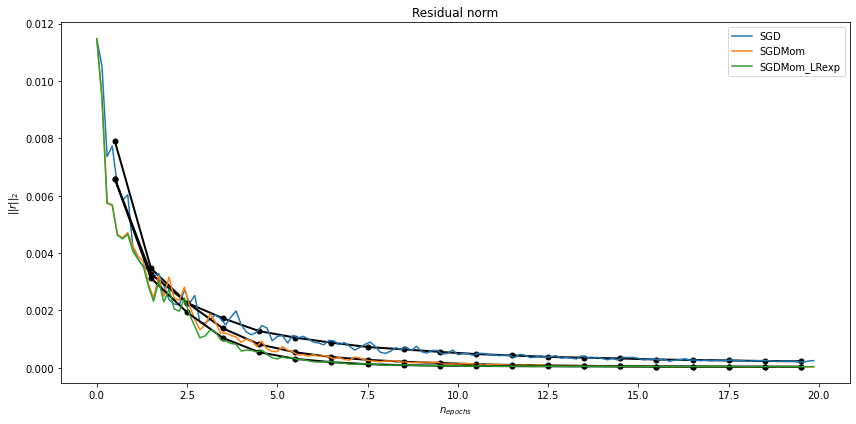

In [48]:
fig = plt.figure(figsize= (12,6))
for loss, avg in zip(lossdict.keys(), avgdict.keys()):
    plt.plot((np.arange(0, no_of_batches*nepochs, no_of_batches))/no_of_batches+0.5, avgdict[avg], '.-k', ms=10,
             linewidth = 2)
    plt.plot(np.arange(len(lossdict[loss]))/no_of_batches , lossdict[loss], label = loss)
plt.xlabel(r'$n_{epochs}$')
plt.ylabel(r'$||r||_2$')
plt.title("Residual norm")
plt.legend()
plt.tight_layout()
plt.savefig('Figs/MDDSingle_residual_norms_batch%d_nepoch%d' % (batch_size, nepochs))

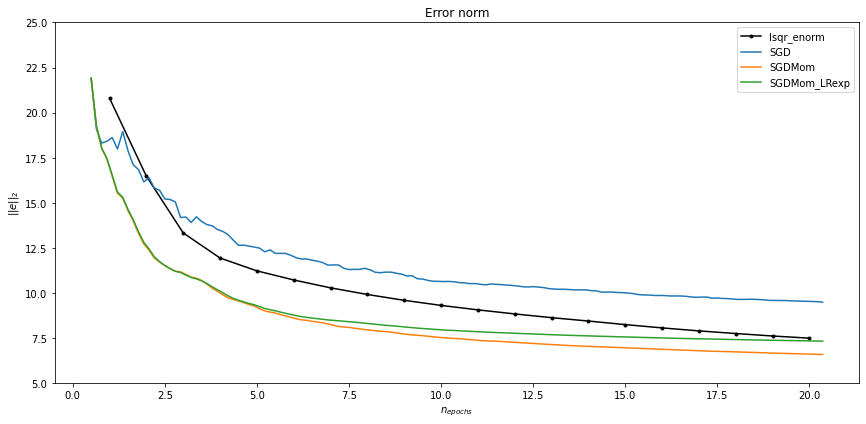

In [49]:
fig = plt.figure(figsize= (12,6))
plt.plot(np.arange(nepochs)+1, bench_enorm[:nepochs], '.-k', label = "lsqr_enorm")
for enorm in enormdict.keys():
    plt.plot(np.arange(len(enormdict[enorm]))/no_of_batches + 0.5, enormdict[enorm], label=enorm)
plt.xlabel(r'$n_{epochs}$')
plt.ylabel(r'$||e||_2$')
plt.title("Error norm")
plt.legend()
plt.tight_layout()
plt.ylim(5, 25)
plt.savefig('Figs/MDDSingle_error_norms_batch%d_nepoch%d' % (batch_size, nepochs))